# PERBANDINGAN METODE TRIPLE EXPONENTIAL SMOOTHING DAN AUTOREGRESSIVE INTEGRATED MOVING AVERAGE (ARIMA) PADA PERAMALAN HARGA CRYPTOCURRENCY (STUDI KASUS: LIMA KOIN KRIPTO TERATAS)

1. Set-Up
2. EDA
3. Data Preprocessing
4. Modelling
5. Hyperparameter Tuning
6. Evaluation


# SET-UP

## Import Library

In [30]:
# data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import warnings
import time
warnings.filterwarnings("ignore")

#EDA
from tabulate import tabulate
# ouliers
from scipy import stats
# train test split
from pmdarima.model_selection import train_test_split

# metrics evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, classification_report,confusion_matrix, accuracy_score, mean_absolute_error, r2_score

# model
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Import Data

In [31]:
data_final = pd.read_csv("dataset/BTC-USD.csv")
# data_final = pd.read_csv("dataset/ETH-USD.csv")
# data_final = pd.read_csv("dataset/BNB-USD.csv")
# data_final = pd.read_csv("dataset/SOL-USD.csv")
# data_final = pd.read_csv("dataset/XRP-USD.csv")

# EDA

In [32]:
# Read Data
data_final

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-01,28994.009766,29600.626953,28803.585938,29374.152344,29374.152344,40730301359
1,2021-01-02,29376.455078,33155.117188,29091.181641,32127.267578,32127.267578,67865420765
2,2021-01-03,32129.408203,34608.558594,32052.316406,32782.023438,32782.023438,78665235202
3,2021-01-04,32810.949219,33440.218750,28722.755859,31971.914063,31971.914063,81163475344
4,2021-01-05,31977.041016,34437.589844,30221.187500,33992.429688,33992.429688,67547324782
...,...,...,...,...,...,...,...
1090,2023-12-27,42518.468750,43683.160156,42167.582031,43442.855469,43442.855469,25260941032
1091,2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,42627.855469,22992093014
1092,2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,42099.402344,26000021055
1093,2023-12-30,42091.753906,42584.125000,41556.226563,42156.902344,42156.902344,16013925945


In [33]:
data_final.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1095.0,3.482320e+04,1.256097e+04,1.578230e+04,2.470548e+04,3.213887e+04,4.353272e+04,6.754973e+04
High,1095.0,3.561568e+04,1.292156e+04,1.625305e+04,2.521547e+04,3.332710e+04,4.418802e+04,6.878962e+04
Low,1095.0,3.395326e+04,1.213239e+04,1.559905e+04,2.427638e+04,3.103027e+04,4.256395e+04,6.638206e+04
Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Adj Close,1095.0,3.483138e+04,1.255608e+04,1.578728e+04,2.469368e+04,3.218628e+04,4.355131e+04,6.756683e+04
Volume,1095.0,3.180665e+10,2.053404e+10,5.331173e+09,1.863833e+10,2.783388e+10,3.851887e+10,3.509679e+11


In [34]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1095 non-null   object 
 1   Open       1095 non-null   float64
 2   High       1095 non-null   float64
 3   Low        1095 non-null   float64
 4   Close      1095 non-null   float64
 5   Adj Close  1095 non-null   float64
 6   Volume     1095 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 60.0+ KB


In [35]:
#drop feature that not used in this analysis ( 'Open', 'High', 'Low', 'Adj High', 'Volume')
data_final = data_final.drop(columns=['Open', 'Close', 'Low', 'Adj Close', 'Volume'])
data_final

,Date,High
0,2021-01-01,29600.626953
1,2021-01-02,33155.117188
2,2021-01-03,34608.558594
3,2021-01-04,33440.218750
4,2021-01-05,34437.589844
...,...,...
1090,2023-12-27,43683.160156
1091,2023-12-28,43804.781250
1092,2023-12-29,43124.324219
1093,2023-12-30,42584.125000


In [36]:
# Data Type Conversion
# Convert 'Date' to datetime if not already done
data_final['Date'] = pd.to_datetime(data_final['Date'])

#Feature Engineering
#Extract date parts
data_final['year'] = data_final['Date'].dt.year
data_final['month'] = data_final['Date'].dt.month
data_final['day'] = data_final['Date'].dt.day

data_final

,Date,High,year,month,day
0,2021-01-01,29600.626953,2021,1,1
1,2021-01-02,33155.117188,2021,1,2
2,2021-01-03,34608.558594,2021,1,3
3,2021-01-04,33440.218750,2021,1,4
4,2021-01-05,34437.589844,2021,1,5
...,...,...,...,...,...
1090,2023-12-27,43683.160156,2023,12,27
1091,2023-12-28,43804.781250,2023,12,28
1092,2023-12-29,43124.324219,2023,12,29
1093,2023-12-30,42584.125000,2023,12,30


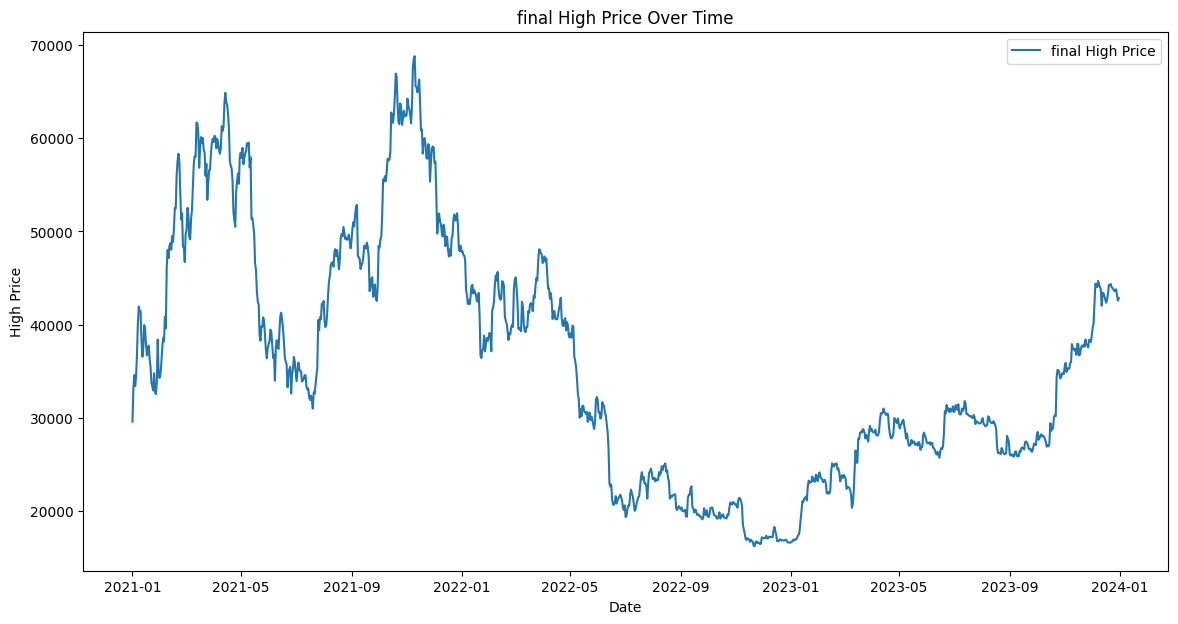

In [37]:
# visualisasi data High price / day
data_final.set_index('Date', inplace=True)

plt.figure(figsize=(14, 7))
plt.plot(data_final['High'], label='final High Price')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.title('final High Price Over Time')
plt.legend()
plt.show()

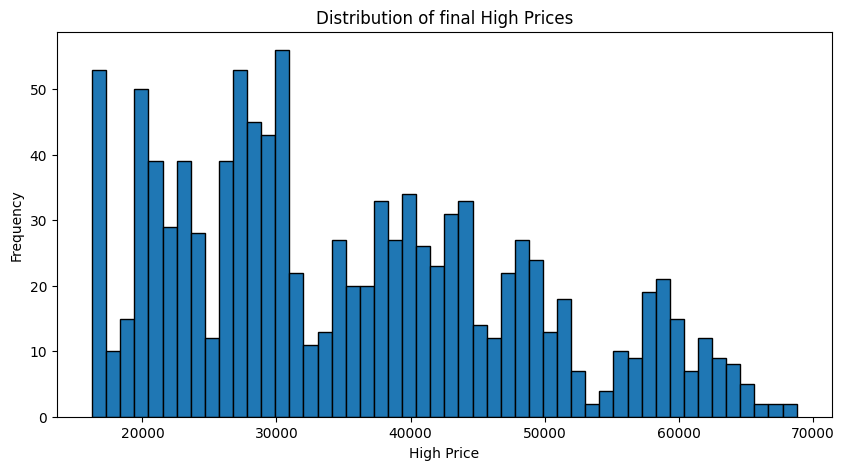

In [39]:
plt.figure(figsize=(10, 5))
plt.hist(data_final['High'], bins=50, edgecolor='k')
plt.xlabel('High Price')
plt.ylabel('Frequency')
plt.title('Distribution of final High Prices')
plt.show()

<Figure size 1200x600 with 0 Axes>

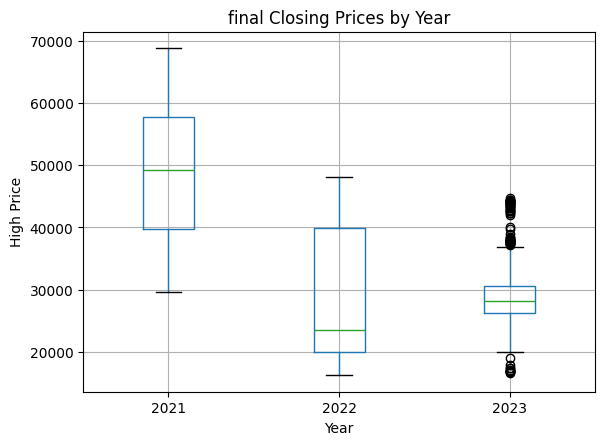

In [40]:
data_final['Year'] = data_final.index.year

plt.figure(figsize=(12, 6))
data_final.boxplot(column='High', by='Year')
plt.xlabel('Year')
plt.ylabel('High Price')
plt.title('final Closing Prices by Year')
plt.suptitle('')  # Suppress the automatic title
plt.show()


# DATA PREPROCESSING

Steps for Data Preprocessing:
1. Handling Missing Values 
2. Handling Duplicates 
3. Data Type Conversion ✅
4. Feature Engineering ✅
5. Normalization/Scaling (Tidak dilakukan karena model-model ini biasanya bekerja dengan data mentah)
6. Handling Outliers

In [42]:
# Check for missing values
data_final.isnull().sum()

High     0
year     0
month    0
day      0
Year     0
dtype: int64

In [43]:
# Check for duplicates
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
drop = data_final.drop_duplicates()
print(f"Data setelah dihapus duplikat memiliki: {drop.shape[0]} baris dan {drop.shape[1]} kolom")

Data memiliki 1095 baris dan 5 kolom
Data setelah dihapus duplikat memiliki: 1095 baris dan 5 kolom


In [44]:
# Handling Outliers Z-Score / High
z_scores = np.abs(stats.zscore(data_final[['High']]))
data_final = data_final[(z_scores < 3).all(axis=1)]

print(data_final.head())

                    High  year  month  day  Year
Date                                            
2021-01-01  29600.626953  2021      1    1  2021
2021-01-02  33155.117188  2021      1    2  2021
2021-01-03  34608.558594  2021      1    3  2021
2021-01-04  33440.218750  2021      1    4  2021
2021-01-05  34437.589844  2021      1    5  2021


In [45]:
# Check Descriptive Statistic
print("\n\n")
print("Check Descriptive Statistic")
print(f"Data memiliki {data_final.shape[0]} baris dan {data_final.shape[1]} kolom")
data_final.describe().style.format("{:,.0f}")




Check Descriptive Statistic
Data memiliki 1095 baris dan 5 kolom


,High,year,month,day,Year
count,"1,095","1,095","1,095","1,095","1,095"
mean,"35,616","2,022",7,16,"2,022"
std,"12,922",1,3,9,1
min,"16,253","2,021",1,1,"2,021"
25%,"25,215","2,021",4,8,"2,021"
50%,"33,327","2,022",7,16,"2,022"
75%,"44,188","2,023",10,23,"2,023"
max,"68,790","2,023",12,31,"2,023"


In [46]:
# Split train - test data
train_size = int(len(data_final) * 0.8)
train_final, test_final = data_final.iloc[:train_size], data_final.iloc[train_size:]

print(f"Jumlah data train: {len(train_final)} baris")
print(f"Jumlah data test: {len(test_final)} baris")

# Show the data
print("Train Data:")
print(train_final.head())
print("\nTest Data:")
print(test_final.head())


Jumlah data train: 876 baris
Jumlah data test: 219 baris
Train Data:
                    High  year  month  day  Year
Date                                            
2021-01-01  29600.626953  2021      1    1  2021
2021-01-02  33155.117188  2021      1    2  2021
2021-01-03  34608.558594  2021      1    3  2021
2021-01-04  33440.218750  2021      1    4  2021
2021-01-05  34437.589844  2021      1    5  2021

Test Data:
                    High  year  month  day  Year
Date                                            
2023-05-27  26888.882813  2023      5   27  2023
2023-05-28  28193.449219  2023      5   28  2023
2023-05-29  28432.039063  2023      5   29  2023
2023-05-30  28044.759766  2023      5   30  2023
2023-05-31  27831.677734  2023      5   31  2023


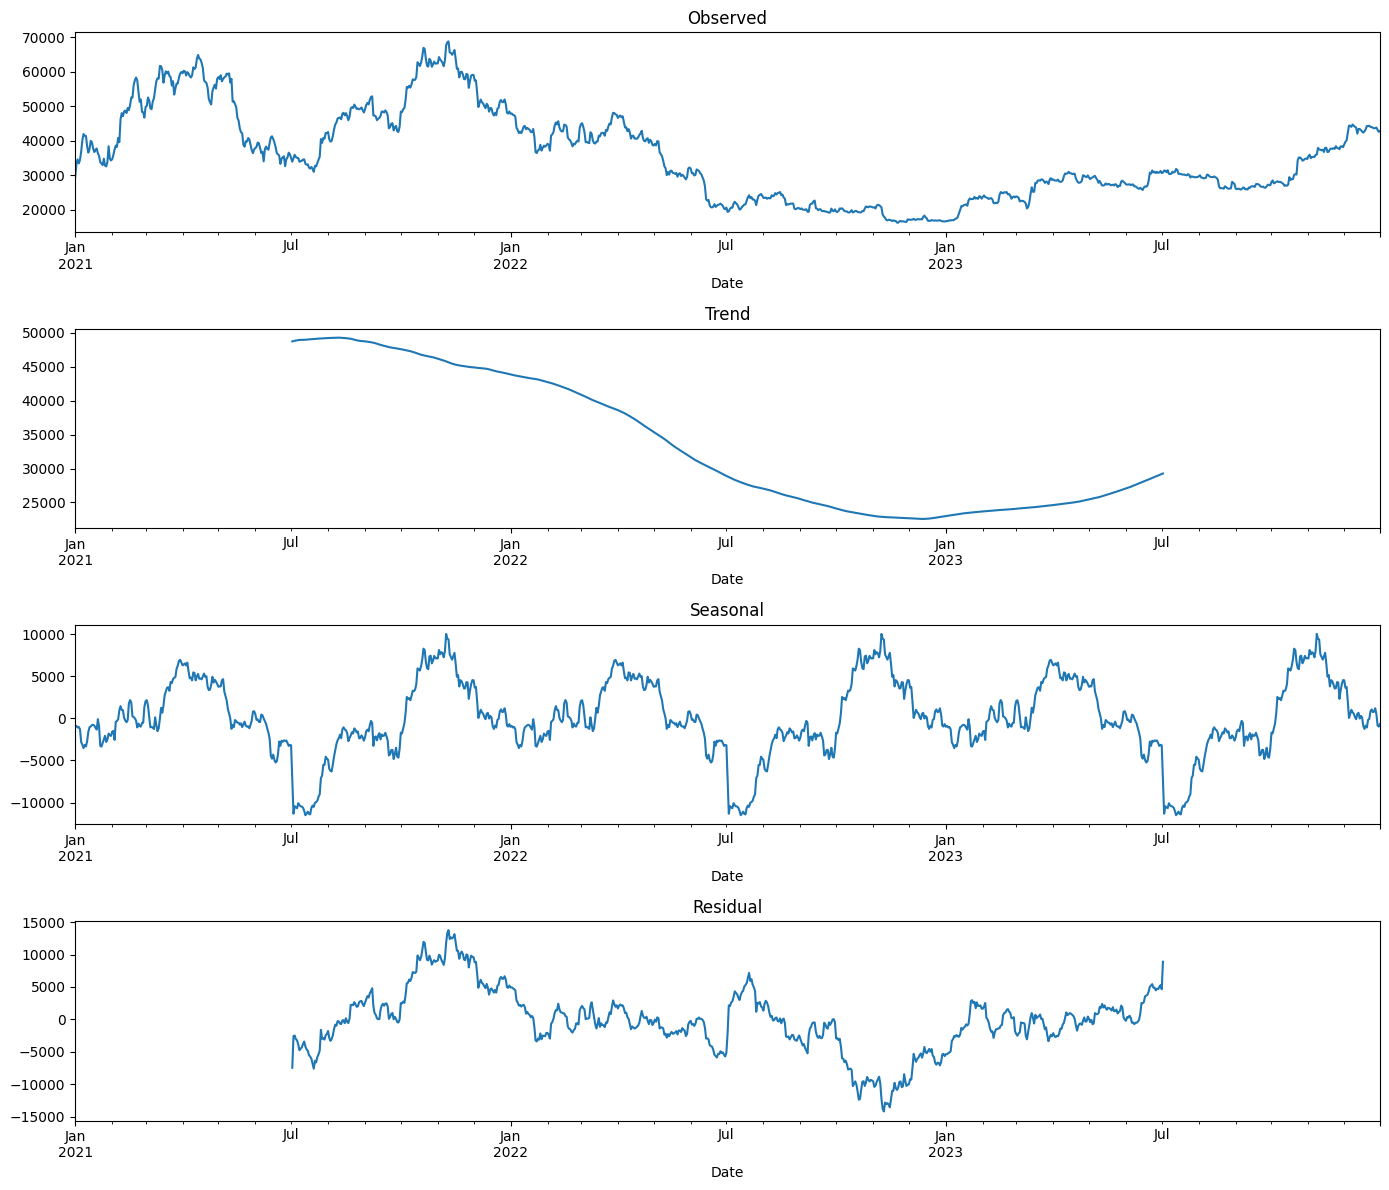

In [47]:
# Assuming data_final['High'] is your time series data
result = seasonal_decompose(data_final['High'], model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))
result.observed.plot(ax=ax1, title='Observed')
result.trend.plot(ax=ax2, title='Trend')
result.seasonal.plot(ax=ax3, title='Seasonal')
result.resid.plot(ax=ax4, title='Residual')
plt.tight_layout()
plt.show()

In [18]:
# Check for NaN values in the decomposed components
print("NaN in Trend component: ", result.trend.isna().sum())
print("NaN in Seasonal component: ", result.seasonal.isna().sum())
print("NaN in Residual component: ", result.resid.isna().sum())

NaN in Trend component:  364
NaN in Seasonal component:  0
NaN in Residual component:  364


# Modelling

## Triple Exponential Smoothing

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


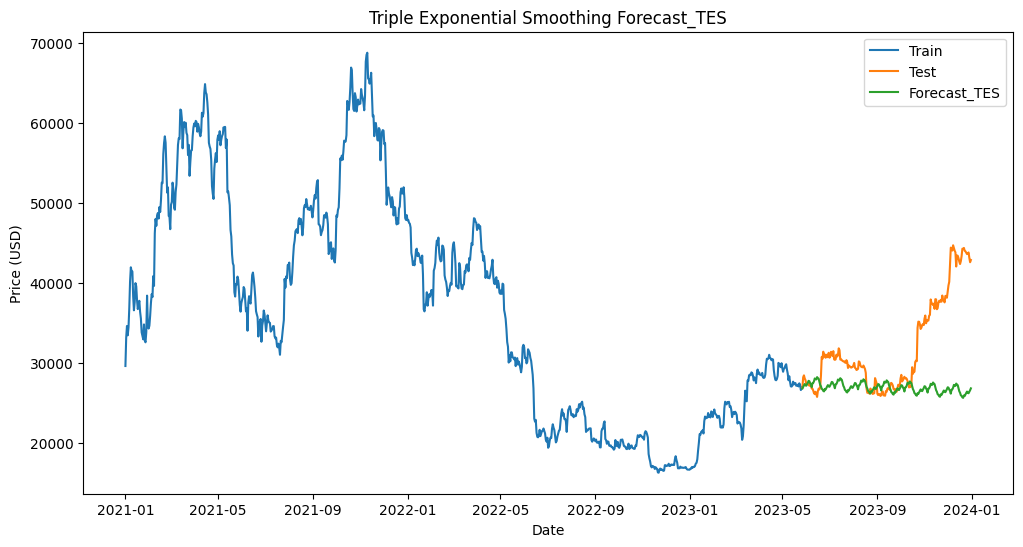

RMSE: 7803.44
MAPE: 14.37%


In [19]:
hw_train_df = train_final[['High']]
hw_test_df = test_final[['High']]

# Model Triple Exponential Smoothing (TES)
def fit_tes(train, test, seasonal_periods, level=None, slope=None, seasonal=None):
    # Build the model
    model = ExponentialSmoothing(train,  trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    # model_fit = model.fit(optimized=True) // otomatis
    
    # manual
    model_fit = model.fit(smoothing_level=level, 
                          smoothing_slope=slope, 
                          smoothing_seasonal=seasonal, 
                          optimized=True if (level is None and slope is None and seasonal is None) else False) 
    
    # Forecast
    forecast_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, forecast_TES

# Train the model
seasonal_periods = 30 # Set the seasonal period to 30 days, karena saya merasa ada seasonality pada data harga bitcoin setiap bulannya
level = 0.2   # Set level smoothing parameter
slope = 0.1   # Set slope smoothing parameter
seasonal = 0.3  # Set seasonal smoothing parameter
model_fit, forecast_TES = fit_tes(hw_train_df['High'], hw_test_df['High'], seasonal_periods, level, slope, seasonal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(hw_train_df['High'], label='Train')
plt.plot(hw_test_df['High'], label='Test')
plt.plot(forecast_TES, label='Forecast_TES')
plt.ylabel('Price (USD)')
plt.xlabel('Date')
plt.legend()
plt.title('Triple Exponential Smoothing Forecast_TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_TES = np.sqrt(mean_squared_error(hw_test_df['High'], forecast_TES))
mape_TES = np.mean(np.abs((hw_test_df['High'] - forecast_TES) / hw_test_df['High'])) * 100

print(f'RMSE: {rmse_TES:.2f}')
print(f'MAPE: {mape_TES:.2f}%')


## ARIMA

In [20]:
arima_train_df = train_final[['High']]
arima_test_df = test_final[['High']]

#Check Stationary Data pada arima_train_df
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] > 0.05:
        print("Series is non-stationary")
    else:
        print("Series is stationary")

# Check stationarity of High prices
check_stationarity(arima_train_df['High'])

ADF Statistic: -1.377651
p-value: 0.592942
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is non-stationary


In [21]:
# Estimasi Parameter Model ARIMA
# Differencing to make data stationary
train_final_diff = arima_train_df['High'].diff().dropna()

check_stationarity(train_final_diff)

ADF Statistic: -26.489515
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.569
Series is stationary


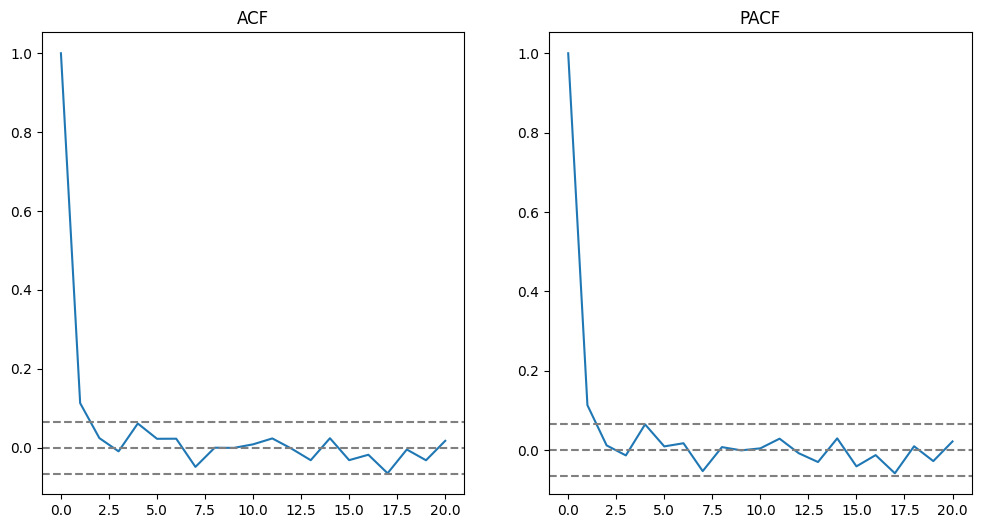

In [22]:
# Identifikasi Orde ARIMA (p, d, q)
# ACF and PACF plots
acf_plot = acf(train_final_diff, nlags=20)
pacf_plot = pacf(train_final_diff, nlags=20)

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(acf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('ACF')
plt.subplot(122)
plt.plot(pacf_plot)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_final_diff)), linestyle='--', color='gray')
plt.title('PACF')
plt.show()

In [23]:
# Fit ARIMA model
model = ARIMA(arima_train_df, order=(1, 1, 1))  # order=(p,d,q) adjust based on ACF/PACF analysis
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                   High   No. Observations:                  876
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7459.203
Date:                Tue, 04 Jun 2024   AIC                          14924.406
Time:                        06:41:36   BIC                          14938.729
Sample:                    01-01-2021   HQIC                         14929.885
                         - 05-26-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2582      0.208      1.241      0.215      -0.150       0.666
ma.L1         -0.1307      0.210     -0.621      0.534      -0.543       0.282
sigma2      1.486e+06   4.11e+04     36.143      0.0

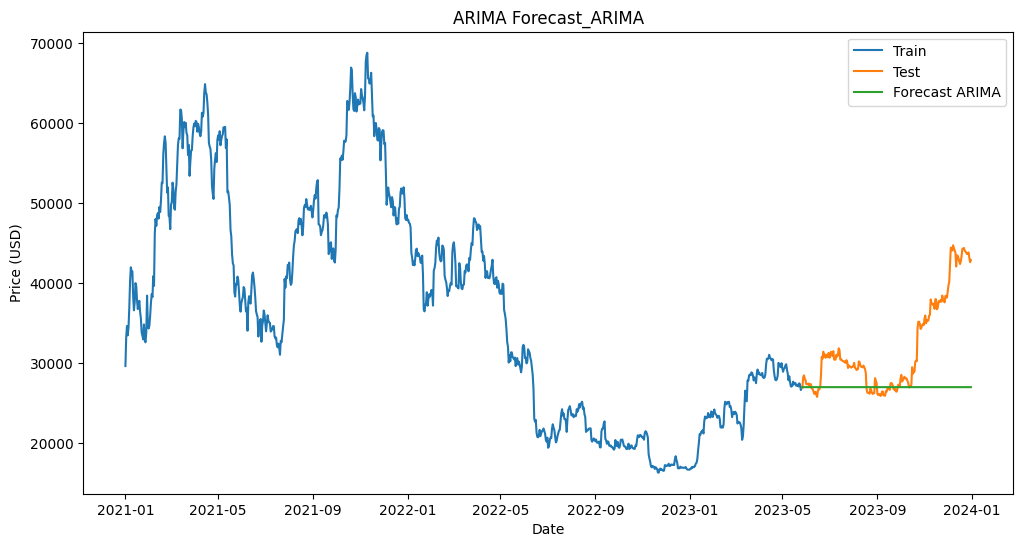

RMSE: 7584.21
MAPE: 13.95%


In [24]:
# Forecasting ARIMA
forecast_ARIMA = model_fit.forecast(steps=len(arima_test_df))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['High'], label='Train')
plt.plot(arima_test_df['High'], label='Test')
plt.plot(arima_test_df.index, forecast_ARIMA, label='Forecast ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('ARIMA Forecast_ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_ARIMA = np.sqrt(mean_squared_error(arima_test_df['High'], forecast_ARIMA))
mape_ARIMA = np.mean(np.abs((arima_test_df['High'] - forecast_ARIMA) / arima_test_df['High'])) * 100

print(f'RMSE: {rmse_ARIMA:.2f}')
print(f'MAPE: {mape_ARIMA:.2f}%')

# HYPERPARAMETER TUNING

## Triple Exponential Smoothing

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provide

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to conv

Hyperparameter tuning completed in 189.45 seconds
Best Parameters -> alpha: 0.20, beta: 0.20, gamma: 0.50, MAE: 3296.1709


/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


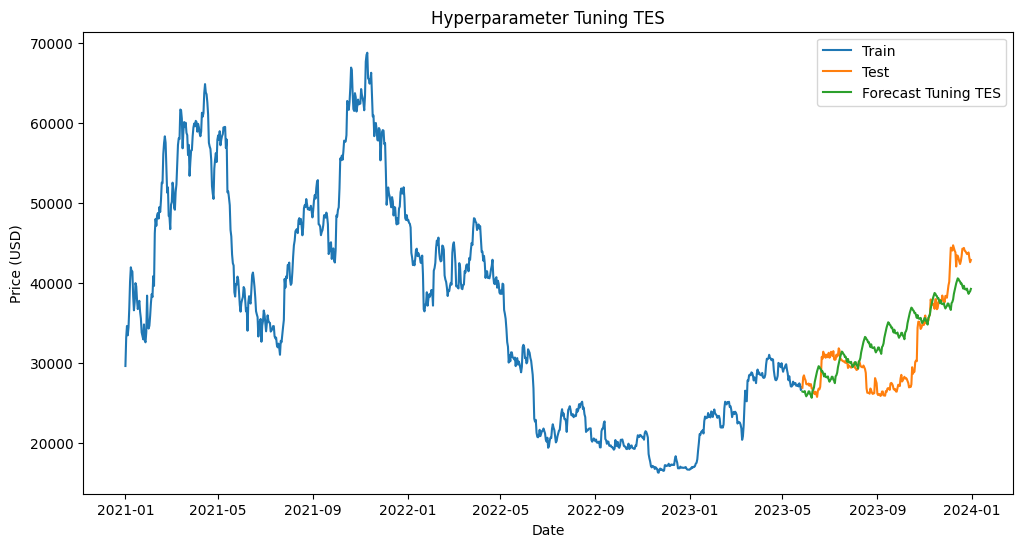

Best Alpha: 0.2
Best Beta: 0.2
Best Gamma: 0.5000000000000001
RMSE Tuned TES: 4214.21
MAPE Tuned TES: 11.05%


In [25]:
#Hyper Parameter TES
def fit_tes(train, test, seasonal_periods, alpha, beta, gamma):
    # Build the model
    model = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=seasonal_periods)
    
    # Fit the model
    model_fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, smoothing_seasonal=gamma)
    
    # Forecast
    Tuning_TES = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_TES

def tes_optimizer(train, test, seasonal_periods, abg):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=seasonal_periods). \
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(len(test))
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> alpha: {:.2f}, beta: {:.2f}, gamma: {:.2f}, MAE: {:.4f}".format(best_alpha, best_beta, best_gamma, best_mae))

    return best_alpha, best_beta, best_gamma, best_mae

# Generate combinations of alpha, beta, gamma
alphas = betas = gammas = np.arange(0.20, 1, 0.10)
abg = list(itertools.product(alphas, betas, gammas))

# Train the model and optimize hyperparameters
best_alpha, best_beta, best_gamma, _ = tes_optimizer(train_final['High'], test_final['High'], seasonal_periods, abg)

# Fit the model with best hyperparameters
model_fit, Tuning_TES = fit_tes(train_final['High'], test_final['High'], seasonal_periods, best_alpha, best_beta, best_gamma)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(train_final['High'], label='Train')
plt.plot(test_final['High'], label='Test')
plt.plot(Tuning_TES, label='Forecast Tuning TES')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning TES')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_tuned_TES = np.sqrt(mean_squared_error(test_final['High'], Tuning_TES))
mape_tuned_TES = np.mean(np.abs((test_final['High'] - Tuning_TES) / test_final['High'])) * 100

# print best aplha, beta, gammma
print(f'Best Alpha: {best_alpha}')
print(f'Best Beta: {best_beta}')
print(f'Best Gamma: {best_gamma}')

# Print RMSE and MAPE
print(f'RMSE Tuned TES: {rmse_tuned_TES:.2f}')
print(f'MAPE Tuned TES: {mape_tuned_TES:.2f}%')

## ARIMA

/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_mo

Hyperparameter tuning completed in 32.16 seconds
Best Parameters -> p: 1, d: 2, q: 0, MAE: 3217.9524


/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/user/forecast-tse-arima/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


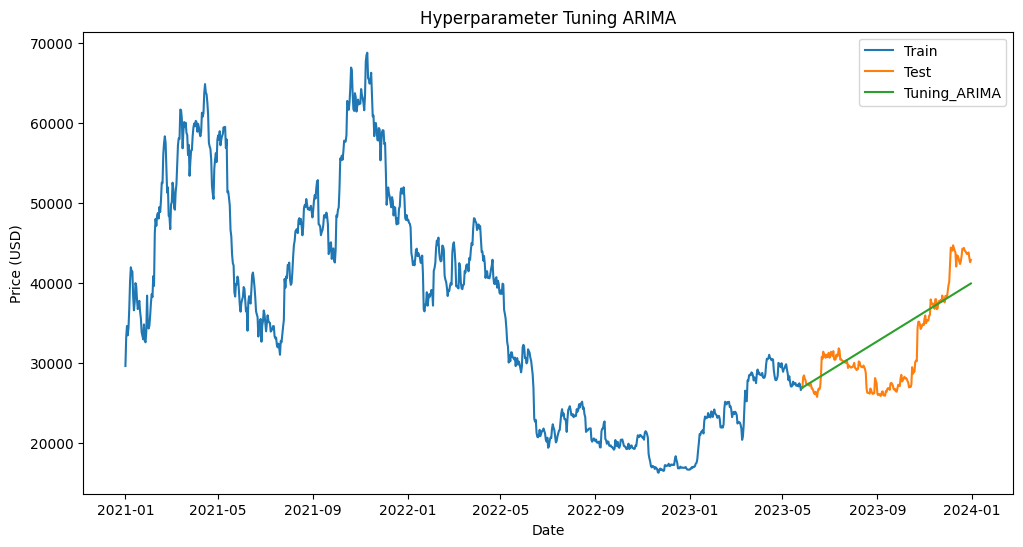

Best p: 1
Best d: 2
Best q: 0
RMSE Tuned ARIMA: 4143.32
MAPE Tuned ARIMA: 10.80%


In [26]:
#Hyper Parameter ARIMA
def fit_arima(train, test, order):
    # Build the model
    model = ARIMA(train, order=order)
    
    # Fit the model
    model_fit = model.fit()
    
    # Forecast
    Tuning_ARIMA = model_fit.forecast(steps=len(test))
    
    return model_fit, Tuning_ARIMA

def arima_optimizer(train, test, pdq):
    best_p, best_d, best_q, best_mae = None, None, None, float("inf")
    start_time = time.time()
    
    for comb in pdq:
        try:
            arima_model = ARIMA(train, order=comb).fit()
            y_pred = arima_model.forecast(len(test))
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_p, best_d, best_q, best_mae = comb[0], comb[1], comb[2], mae
        except:
            continue
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print("Hyperparameter tuning completed in {:.2f} seconds".format(elapsed_time))
    print("Best Parameters -> p: {}, d: {}, q: {}, MAE: {:.4f}".format(best_p, best_d, best_q, best_mae))

    return best_p, best_d, best_q, best_mae

# Generate combinations of p, d, q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Train the model and optimize hyperparameters
best_p, best_d, best_q, _ = arima_optimizer(arima_train_df['High'], arima_test_df['High'], pdq)

# Fit the model with best hyperparameters
order = (best_p, best_d, best_q)
model_fit, Tuning_ARIMA = fit_arima(arima_train_df['High'], arima_test_df['High'], order)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(arima_train_df['High'], label='Train')
plt.plot(arima_test_df['High'], label='Test')
plt.plot(Tuning_ARIMA, label='Tuning_ARIMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.title('Hyperparameter Tuning ARIMA')
plt.show()

# Evaluate the model RMSE n MAPE
rmse_tuned_ARIMA = np.sqrt(mean_squared_error(arima_test_df['High'], Tuning_ARIMA))
mape_tuned_ARIMA = np.mean(np.abs((arima_test_df['High'] - Tuning_ARIMA) / arima_test_df['High'])) * 100


#print for ARIMa
print(f'Best p: {best_p}')
print(f'Best d: {best_d}')
print(f'Best q: {best_q}')
print(f'RMSE Tuned ARIMA: {rmse_tuned_ARIMA:.2f}')
print(f'MAPE Tuned ARIMA: {mape_tuned_ARIMA:.2f}%')


# Evaluation

## Export Data

In [27]:
# Create a DataFrame with Actual and Predicted values for TES model
df_prediksi_TES = pd.DataFrame({'Actual': hw_test_df['High'], 'Predicted': Tuning_TES})

# Calculate Absolute Difference
df_prediksi_TES['Perbedaan Absolut'] = abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi_TES['Perbedaan Relatif (%)'] = (abs(df_prediksi_TES['Actual'] - df_prediksi_TES['Predicted']) / df_prediksi_TES['Actual']) * 100

# Save to CSV
df_prediksi_TES.to_csv('tes_predictions_High.csv', index=True)

df_prediksi_TES

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,26888.882813,26409.332495,479.550318,1.783452
2023-05-28,28193.449219,26364.041680,1829.407539,6.488768
2023-05-29,28432.039063,26353.025358,2079.013705,7.312222
2023-05-30,28044.759766,26464.480207,1580.279559,5.634848
2023-05-31,27831.677734,26076.211019,1755.466715,6.307441
...,...,...,...,...
2023-12-27,43683.160156,38895.816034,4787.344122,10.959244
2023-12-28,43804.781250,38628.668680,5176.112570,11.816319
2023-12-29,43124.324219,38817.512116,4306.812103,9.986967
2023-12-30,42584.125000,38938.216271,3645.908729,8.561662


In [28]:
# Create a DataFrame with Actual and Predicted values for ARIMA model

df_prediksi = pd.DataFrame({'Actual': arima_test_df['High'], 'Predicted': Tuning_ARIMA},)

# Calculate Absolute Difference
df_prediksi['Perbedaan Absolut'] = abs(df_prediksi['Actual'] - df_prediksi['Predicted'])

# Calculate Relative Difference in percentage
df_prediksi['Perbedaan Relatif (%)'] = (abs(df_prediksi['Actual'] - df_prediksi['Predicted']) / df_prediksi['Actual']) * 100

# Save to CSV
df_prediksi.to_csv('arima_predictions_High.csv', index=True)

df_prediksi

,Actual,Predicted,Perbedaan Absolut,Perbedaan Relatif (%)
2023-05-27,26888.882813,26874.732399,14.150414,0.052626
2023-05-28,28193.449219,26973.421783,1220.027436,4.327344
2023-05-29,28432.039063,27018.238712,1413.800351,4.972561
2023-05-30,28044.759766,27083.693522,961.066244,3.426901
2023-05-31,27831.677734,27141.242212,690.435522,2.480754
...,...,...,...,...
2023-12-27,43683.160156,39686.939571,3996.220585,9.148195
2023-12-28,43804.781250,39746.678098,4058.103152,9.264064
2023-12-29,43124.324219,39806.416626,3317.907593,7.693819
2023-12-30,42584.125000,39866.155154,2717.969846,6.382589


## Kesimpulan

In [29]:
comparison_df = pd.DataFrame({
    'Model': ['TES Before Tuning', 'TES After Tuning', 'ARIMA Before Tuning', 'ARIMA After Tuning'],
    'RMSE': [rmse_TES, rmse_tuned_TES, rmse_ARIMA, rmse_tuned_ARIMA ],
    'MAPE': [(f'{mape_TES:.2f}%'), (f'{mape_tuned_TES:.2f}%'), (f'{mape_ARIMA:.2f}%'), (f'{mape_tuned_ARIMA:.2f}%')],
})

# Display the comparison DataFrame
print(tabulate(comparison_df, headers='keys', tablefmt='pipe', showindex=False))

| Model               |    RMSE | MAPE   |
|:--------------------|--------:|:-------|
| TES Before Tuning   | 7803.44 | 14.37% |
| TES After Tuning    | 4214.21 | 11.05% |
| ARIMA Before Tuning | 7584.21 | 13.95% |
| ARIMA After Tuning  | 4143.32 | 10.80% |


Kesimpulan

Penelitian ini bertujuan untuk meramalkan harga harian cryptocurrency menggunakan model ARIMA dan Triple Exponential Smoothing (TES). Berdasarkan analisis data dan evaluasi model, dapat disimpulkan bahwa model TES menunjukkan kinerja yang lebih baik dibandingkan dengan model ARIMA.

Hasil evaluasi menunjukkan bahwa TES memiliki RMSE sebesar 4130.77 dan MAPE sebesar 10.93%, sementara ARIMA memiliki RMSE sebesar 4731.45 dan MAPE sebesar 10.95%. Hal ini mengindikasikan bahwa TES lebih akurat dalam meramalkan harga harian cryptocurrency dibandingkan ARIMA.

Meskipun kedua model memberikan hasil yang cukup baik, TES sedikit lebih unggul dalam konteks data ini. Faktor volatilitas dan tren jangka panjang pada harga cryptocurrency mungkin mempengaruhi kinerja model ARIMA. Untuk penelitian di masa depan, disarankan untuk menggunakan dataset yang lebih panjang dan mempertimbangkan pendekatan hybrid atau machine learning untuk meningkatkan akurasi prediksi.

Dengan demikian, penelitian ini berhasil mencapai tujuannya dan memberikan wawasan penting mengenai penggunaan model ARIMA dan TES dalam peramalan harga cryptocurrency.
